### Changes in interchromosomal contacts during infection

_A. castellanii_ forms specific inter-telomeric contacts. Here I investigate whether those contacts are disrupted in any way during infection. As interchromosomal contact matrices generally have a poor signal to noise ratio, I use a larger binning (20kb) and use serpentine adaptative binning to improve the signal.


In [69]:
import os
import numpy as np
import pandas
import cooler
import matplotlib.pyplot as plt
import serpentine as serp
import chromosight.utils.detection as cud
os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')
# Input cool files have been generated by subsampling - merging all
clu = cooler.Cooler('uninfected_20kb.cool')
cli = cooler.Cooler('infected_20kb.cool')
matu = clu.matrix(sparse=False, balance=False)[:]
mati = cli.matrix(sparse=False, balance=False)[:]

Now that the low resolution whole genome matrices are loaded, we use serpentine to smooth both matrices and their ratio.

In [7]:
# It takes ages to run, so we cache the output with ipython magic
#seri, seru, srat = serp.serpentin_binning(mati, matu, parallel=1)
#%store seri seru srat

2020-10-27 16:05:10.667360 Starting 10 binning processes...
0	 Total serpentines: 4955076 (100.0 %)
1	 Total serpentines: 3299724 (66.59280301654303 %)
2	 Total serpentines: 1139184 (22.99024273290662 %)
3	 Total serpentines: 421980 (8.516115595401564 %)
4	 Total serpentines: 210910 (4.256443291687151 %)
5	 Total serpentines: 173395 (3.499340877919935 %)
6	 Total serpentines: 171733 (3.4657995154867454 %)
7	 Total serpentines: 171716 (3.465456432958849 %)
7	 Over: 2020-10-27 16:07:10.948279
0	 Total serpentines: 4955076 (100.0 %)
1	 Total serpentines: 3298798 (66.57411510943525 %)
2	 Total serpentines: 1139709 (23.000837928621074 %)
3	 Total serpentines: 422126 (8.51906206887644 %)
4	 Total serpentines: 211299 (4.264293827178433 %)
5	 Total serpentines: 173672 (3.5049311049921332 %)
6	 Total serpentines: 172063 (3.472459352792974 %)
7	 Total serpentines: 172045 (3.472096088939907 %)
7	 Over: 2020-10-27 16:09:14.890300
0	 Total serpentines: 4955076 (100.0 %)
1	 Total serpentines: 329838

In [8]:
%store -r seri seru srat

We see some long red and blue bands. This suggests some chromosome have more or less contacts with the rest of the genome upon infection.

Text(0.5, 0.98, 'Serpentine-binned A. castellanii genome, 20kb')

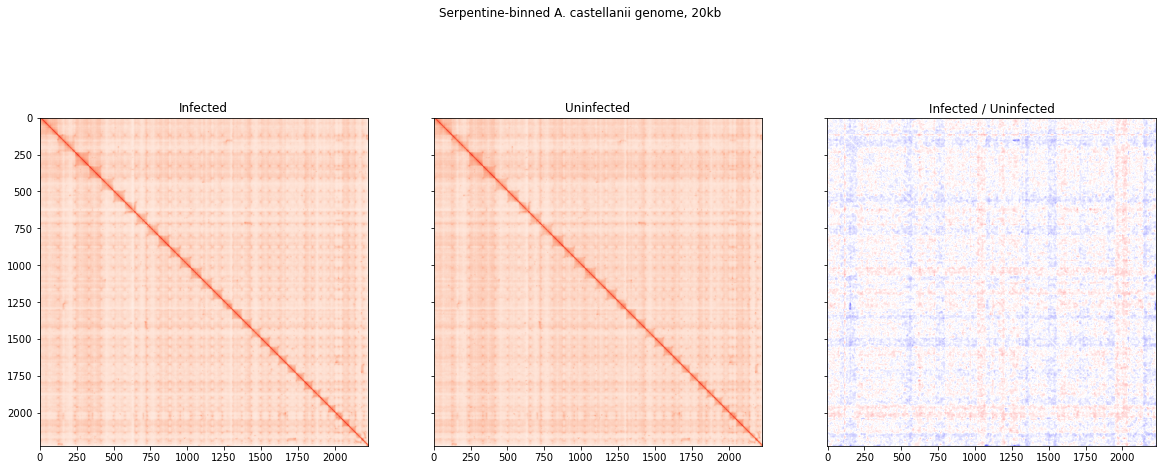

In [154]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, 8))
ax[0].imshow(np.log2(seri), cmap="Reds")
ax[0].set_title("Infected")
ax[1].imshow(np.log2(seru), cmap="Reds")
ax[1].set_title("Uninfected")
ax[2].imshow(srat, cmap="bwr")
ax[2].set_title("Infected / Uninfected")
plt.suptitle("Serpentine-binned A. castellanii genome, 20kb")



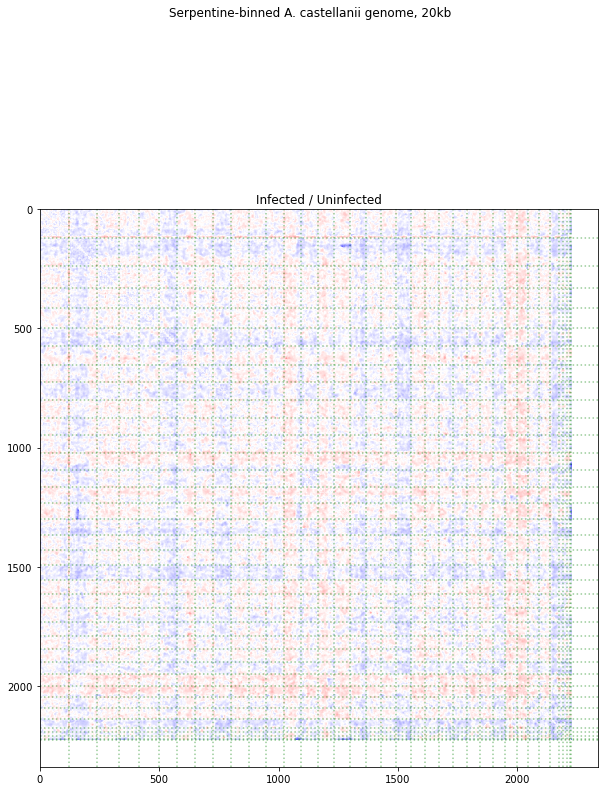

In [158]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
ax.imshow(srat, cmap="bwr")
ax.set_title("Infected / Uninfected")
plt.suptitle("Serpentine-binned A. castellanii genome, 20kb")
for chrom in clu.chroms()[:].name:
    ax.axvline(clu.extent(chrom)[1], alpha=0.4, c='g', ls=':')
    ax.axhline(clu.extent(chrom)[1], alpha=0.4, c='g', ls=':')

Extracting the windows around each inter-telomeric coordinate reveals that most chromosome have stronger telomeric clustering upon infection. There are a few outlier chromosomes which seem to behave differently.

In [112]:
WINRAD = 11
WINSIZE = WINRAD * 2 + 1
chrom_telo_win = {chrom: [] for chrom in clu.chroms()[:].name}
chroms = clu.chroms()[:]
ends = [0, clu.shape[0]]
for c1 in chroms.name:
    for c2 in chroms.name:
        if c1 == c2:  # Skip intra
            continue
        for i in clu.extent(c1):
            for j in clu.extent(c2):
                if i == j: # Skip neighbouring chromosomes (diagonal)
                    continue
                if i in ends or j in ends: # Skip first and last telomeres
                    continue
                win = srat[i-(WINRAD+1): i+WINRAD, j-(WINRAD+1): j+WINRAD]
                if win.shape == (WINSIZE, WINSIZE):
                    chrom_telo_win[c1].append(win)
                    chrom_telo_win[c2].append(win)

In [146]:
chrom_agg = {
    chrom: np.apply_along_axis(np.nanmedian, 2, np.dstack(wins)) for chrom, wins in chrom_telo_win.items() if len(wins)
}

Text(0.5, 0.98, 'Infected / Uninfected telomeric contacts')

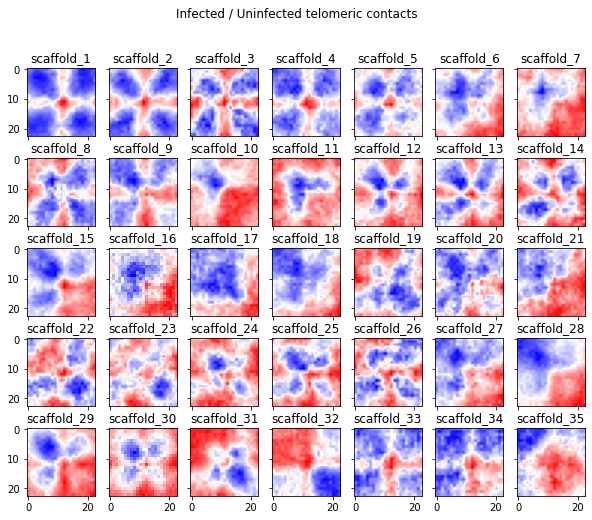

In [148]:
%matplotlib inline
fig, ax = plt.subplots(5, 7, sharex=True, sharey=True, figsize=(10, 8))
for a, (chrom, pileup) in zip(ax.flat, chrom_agg.items()):
    a.imshow(pileup, cmap='bwr')
    a.set_title(chrom)
plt.suptitle("Infected / Uninfected telomeric contacts")
#plt.savefig("~/pCloudDrive/reports_phd/20200617_acastellanii_ms/assets/intertelomeric_infection_ratio.svg")

We can also visualise this as a 4C-like profile. The 4C profile of each chromosome is extracted by taking the sum of interchromsomal contact for each of its bins.

Here, I resized each chromosome's profile so that they are all the same length. We can see that several chromosomes have a very strong contact enrichment towards the centromeres, but this is not the case for all of them.

In [197]:
profiles = {}
for chrom in clu.chroms()[:].name:
    s, e = clu.extent(chrom)
    profiles[chrom] = srat[s:e, :].mean(axis=1)
    

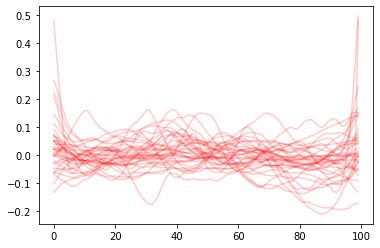

In [212]:
%matplotlib inline
import scipy.ndimage as ndi
img = np.zeros((len(profiles), 100))
for i, (chrom, prof) in enumerate(profiles.items()):
    zoomed = ndi.zoom(prof, 100 / len(prof))
    #img[i, :] = (zoomed - zoomed.mean()) / zoomed.std()
    plt.plot(zoomed - zoomed.mean(), alpha=0.2, c='red')
#plt.imshow(img, cmap='bwr', vmax=2, vmin=-2)

In [245]:
sim_mat = np.zeros((len(profiles), len(profiles)))
for i1, c1 in enumerate(clu.chroms()[:].name):
    for i2, c2 in enumerate(clu.chroms()[:].name):
        if c1 == c2:
            sim_mat[i1, i2] = 1
            continue
        s1, e1 = clu.extent(c1)
        s2, e2 = clu.extent(c2)
        sim_mat[i1, i2] = matu[s1:e1, s2:e2].mean()
        

Text(0.5, 0.98, 'Pairwise interchromosomal contact intensity')

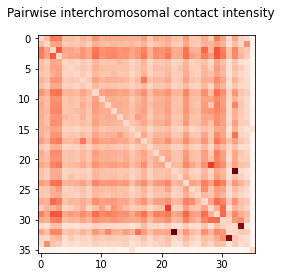

In [246]:
%matplotlib inline
plt.imshow(sim_mat, cmap='Reds')
plt.suptitle("Pairwise interchromosomal contact intensity")

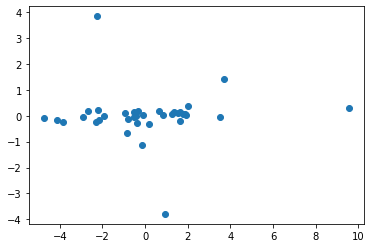

In [247]:
from sklearn.decomposition import PCA
pca = PCA()
pcs = pca.fit_transform(sim_mat)
plt.scatter(pcs[:, 0], pcs[:, 1])

In [248]:
min(sim_mat.flat)

0.009259259259259259

OK let's visualise all that again with a graph in both conditions:

Text(0.5, 0.98, 'Network of interchromosomal contacts')

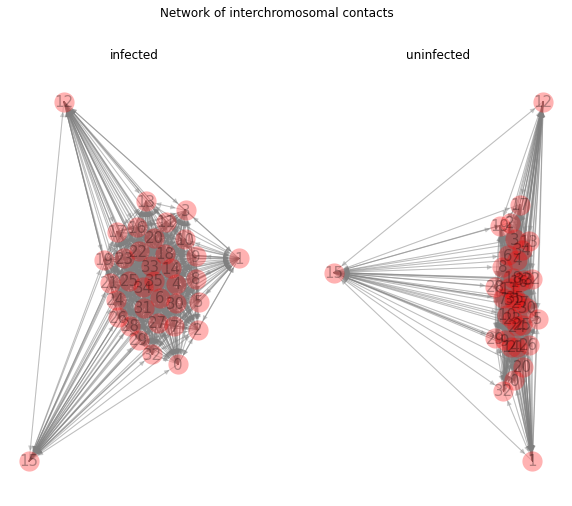

In [253]:
%matplotlib inline
import networkx as nx

def interchrom_graph(clr, mat):
    n_chroms = clr.chroms()[:].shape[0]
    sim_mat = np.zeros((n_chroms, n_chroms))
    for i1, c1 in enumerate(clr.chroms()[:].name):
        for i2, c2 in enumerate(clr.chroms()[:].name):
            if c1 == c2:
                sim_mat[i1, i2] = 1
                continue
            s1, e1 = clr.extent(c1)
            s2, e2 = clr.extent(c2)
            sim_mat[i1, i2] = mat[s1:e1, s2:e2].mean()
    return sim_mat
    
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

for a, m, c in zip(ax.flat, [mati, matu], ['infected', 'uninfected']):
    nx.draw_kamada_kawai(
        nx.DiGraph(interchrom_graph(clu, m)),
        with_labels=True,
        node_color='red',
        node_size=400,
        edge_color='grey',
        linewidths=.1,
        font_size=15,
        alpha=0.3,
        ax=a,
    )
    a.set_title(c)
plt.suptitle("Network of interchromosomal contacts")

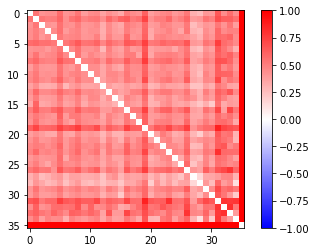

In [273]:
%matplotlib inline
plt.imshow(np.log2(interchrom_graph(clu, mati)/interchrom_graph(clu, matu)), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

The share of interchromosomal contacts increases during infection

In [272]:
intrai = 0
intrau = 0
for chrom in clu.chroms()[:].name:
    s, e = clu.extent(chrom)
    intrai += np.triu(mati[s:e, s:e]).sum()
    intrau += np.triu(matu[s:e, s:e]).sum()
print(f"Infected: {100*(1-intrai / cli.info['sum']):.2f}% interchromosomal contacts")
print(f"Uninfected: {100*(1-intrau / clu.info['sum']):.2f}% interchromosomal contacts")

Infected: 4.96% interchromosomal contacts
Uninfected: 3.61% interchromosomal contacts


What stands out the most here is that scaffold 15 is interacting more

If we want to quantify the strength of telomere clustering before and after infection, so we need to generate a chromosight kernel for telomere clustering.

In [107]:
def get_inter_telo(clr):
    """
    Yields bin coordinates of inter-telomeric positions.
    Skips intrachromosomal and neighbouring chromosome contacts
    """
    chroms = clr.chroms()[:]
    ends = [0, clr.shape[0]]
    for c1 in chroms.name:
        for c2 in chroms.name:
            if c1 == c2:  # Skip intra
                continue
            for i in clu.extent(c1):
                for j in clu.extent(c2):
                    if i == j: # Skip neighbouring chromosomes (diagonal)
                        continue
                    if i in ends or j in ends: # Skip first and last telomeres
                        continue
                    yield(i, j)

In [73]:
# Compute pileup between all pairs of telomeres
wins = []

for i, j in get_inter_telo(clu):
    win = matu[i-(WINRAD+1): i+WINRAD, j-(WINRAD+1): j+WINRAD]
    if win.shape == (WINSIZE, WINSIZE):
        wins.append(win)

wins = np.dstack(wins)
pileup = np.apply_along_axis(np.nanmedian, 2, wins)
# Enforce symmetry by adding all rotations
rot = pileup.copy()
for i in range(3):
    rot = np.rot90(rot)
    pileup += rot

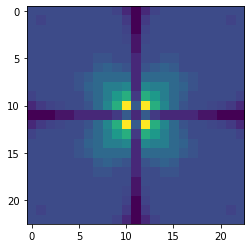

In [74]:
%matplotlib inline
plt.imshow(pileup)

In [82]:
convu, _ = cud.normxcorr2(matu, pileup)
convi, _ = cud.normxcorr2(mati, pileup)

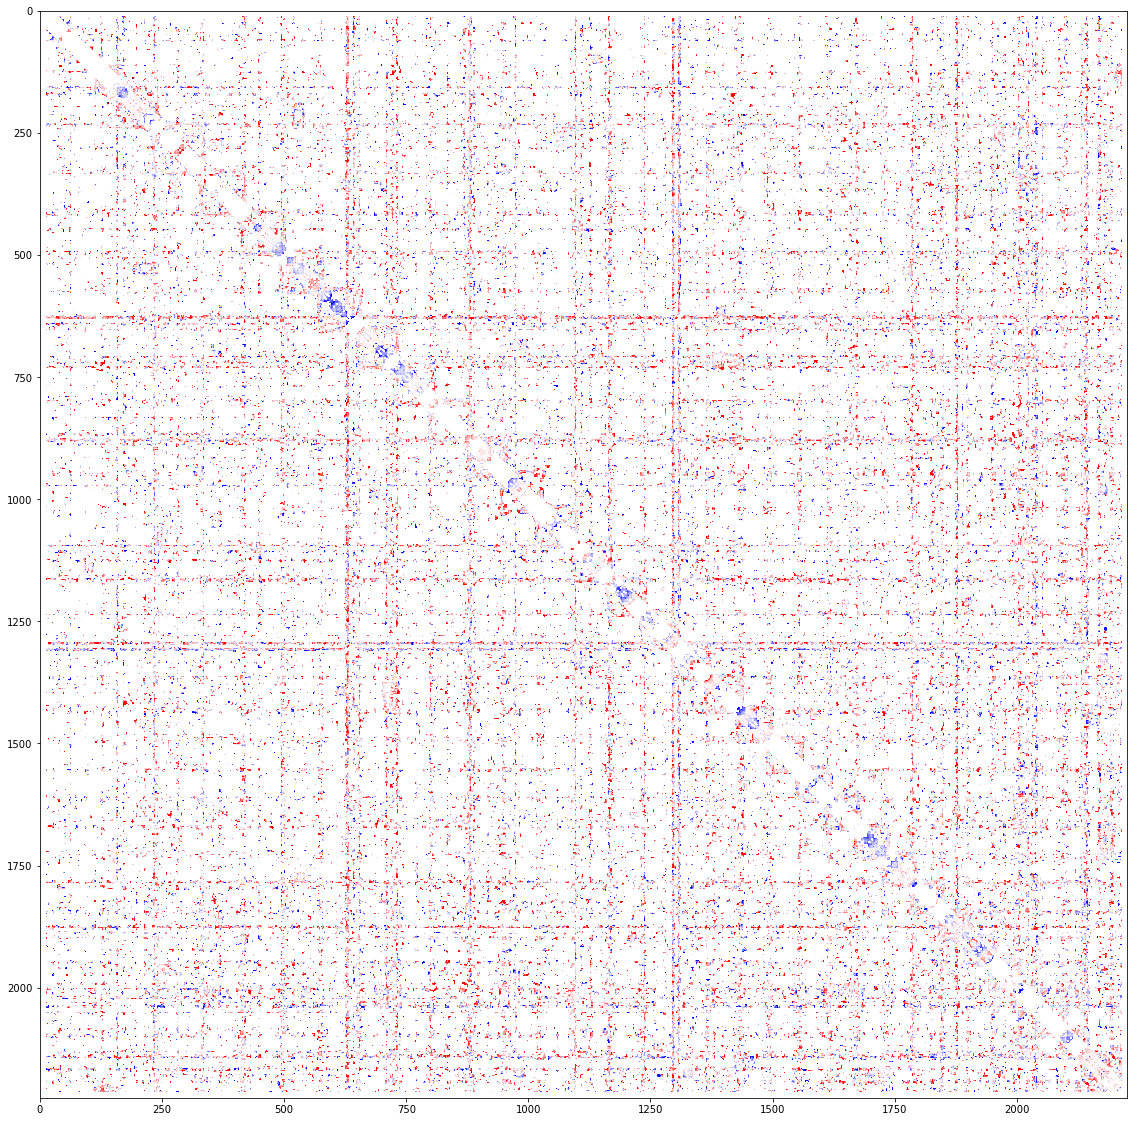

In [90]:
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.imshow(np.log2(convi / convu), vmin=-1, vmax=1, cmap='bwr')

In [93]:
def get_inter_conv_dist_mat(clr, conv):
    """
    Populate a cube of inter-telomeric convolution scores.
    The cube has shape NxNx4 where N is the number of chromosomes.
    4 stands for the combination of start-end interactions.
    Skipped combinations (same chromsome, on diagonal,
    chromosome too small) are set to np.nan
    """
    chroms = clr.chroms()[:]
    inter_conv = np.zeros((chroms.shape[0], chroms.shape[0], 4))
    ends = [0, clr.shape[0]]
    for idx1, c1 in enumerate(chroms.name):
        for idx2, c2 in enumerate(chroms.name):
            if c1 == c2:  # Skip intra
                inter_conv[idx1, idx2, :] = np.nan
                continue
            comb = 0
            for i in clu.extent(c1):
                for j in clu.extent(c2):
                    if i == j: # Skip neighbouring chromosomes (diagonal)
                        inter_conv[idx1, idx2, comb] = np.nan
                        comb += 1
                        continue
                    if i in ends or j in ends: # Skip first and last telomeres
                        inter_conv[idx1, idx2, comb] = np.nan
                        comb += 1
                        continue
                    inter_conv[idx1, idx2, comb] = conv[i, j]
                    comb += 1
    return inter_conv

In [100]:
inter_convu = get_inter_conv_dist_mat(clu, convu)
inter_convi = get_inter_conv_dist_mat(cli, convi)

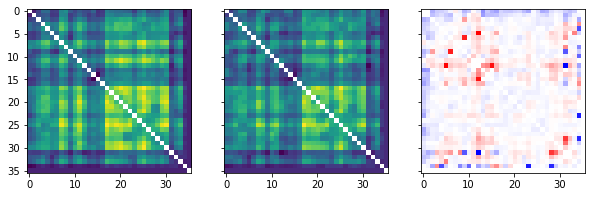

In [106]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 6))
ax[0].imshow(np.apply_along_axis(np.nanmean, 2, inter_convi))
ax[1].imshow(np.apply_along_axis(np.nanmean, 2, inter_convu))
ax[2].imshow(np.log2(np.apply_along_axis(np.nanmean, 2, inter_convi)/np.apply_along_axis(np.nanmean, 2, inter_convu)), cmap='bwr')